The data we use in this project is from [PhysioNet 2016 Challenge](https://physionet.org/content/challenge-2016/1.0.0/)

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import librosa
import librosa.display
import IPython.display as ipd

# Train Set

In [2]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}
df_ref = {}

for key in training:
    
    path = "../train_test_original/"+training[key]+"/REFERENCE-SQI.csv"
    df_ref[key] = pd.read_csv(path, header=None).rename(columns = {
       0:"name", 1:"num_1", 2:"num_2"})


In [3]:
df_ref["a"].head()

,name,num_1,num_2
0,a0001,1,1
1,a0002,1,1
2,a0003,1,1
3,a0004,1,1
4,a0005,1,1


In [4]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

records = {}
df_records = {}


for key in training:
    
    all_rec = "../train_test_original/"+training[key]+"/RECORDS"
    normal  = "../train_test_original/"+training[key]+"/RECORDS-normal"
    abnormal= "../train_test_original/"+training[key]+"/RECORDS-abnormal"

    all_recs = {}
    normals = {}
    abnormals = {}

    with open(all_rec, "r") as rec:
        all_rec = rec.readlines()
        for line in all_rec:
            all_recs[line[:-1]] = 0


    with open(normal, "r") as n:
        n_recs = n.readlines()
        for line in n_recs:
            normals[line[:-1]] = "normal"
        
    with open(abnormal, "r") as ab:
        ab_recs = ab.readlines()
        for line in ab_recs:
            abnormals[line[:-1]] = "abnormal"     
        
        

    for item in all_recs:
        if item in list(normals.keys()):
            all_recs[item] = normals[item]
        else:
            all_recs[item] = abnormals[item]
            
    records[key] = all_recs
    df_records[key] = pd.DataFrame(list(records[key].items()),
                            columns = ['Audio','target'])

    
    

In [5]:
sum = 0
for item in df_records:
    print(item, len(df_records[item]))
    sum += len(df_records[item])
    
print("\n",sum)   

a 409
b 490
c 31
d 55
e 2141
f 114

 3240


In [6]:
df_train = pd.DataFrame()
all_records = pd.DataFrame()
all_ref = pd.DataFrame()

all_records = df_records["a"]
all_ref     = df_ref["a"]

for item in ["b", "c", "d", "e", "f"]:
    all_records = pd.concat([all_records, df_records[item]], axis = 0)
    all_ref     = pd.concat([all_ref, df_ref[item]], axis = 0)

df_train = pd.concat([all_ref, all_records], axis = 1)
df_train.drop(columns = ["num_1","Audio"], inplace = True, axis = 1)
# df_train = df_train.sample(frac = 1)
# df_train.to_csv('df_train.csv')



In [7]:
all_records.head()

,Audio,target
0,a0001,abnormal
1,a0002,abnormal
2,a0003,abnormal
3,a0004,abnormal
4,a0005,abnormal


In [8]:
df_train.duplicated().sum()

0

In [9]:
df_train.isna().sum()

name      0
num_2     0
target    0
dtype: int64

In [10]:
df_train.target.value_counts()

normal      2575
abnormal     665
Name: target, dtype: int64

# Test Set

In [11]:
df_test = {}

path = "../train_test_original/validation/REFERENCE.csv"
df_test = pd.read_csv(path, header=None).rename(columns = {0:"Name",
                                                               1: "target"})

df_test.target = df_test.target.map({1: "abnormal", -1: "normal"})
df_test = df_test.sample(frac = 1)
df_test.to_csv('df_test.csv')


In [12]:
df_test.head()

,Name,target
237,e00043,normal
117,b0038,normal
123,b0044,normal
186,d0002,abnormal
136,b0057,abnormal


In [13]:
df_test.target.value_counts(normalize = True)

abnormal    0.501661
normal      0.498339
Name: target, dtype: float64

# Getting Spectrogram of the Audio Files 

In [50]:
df_train["name"].iloc[0]

'a0001'

In [51]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

### Example
audio_1 = df_train["name"].iloc[2] 
audio_path = "../train_test_original/training-"+ audio_1[0] + "/"+ audio_1 + ".wav"
fig_path = "../spectrograms/"+  audio_1

SAMPLE_RATE = 3000
x, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(92160,) 3000


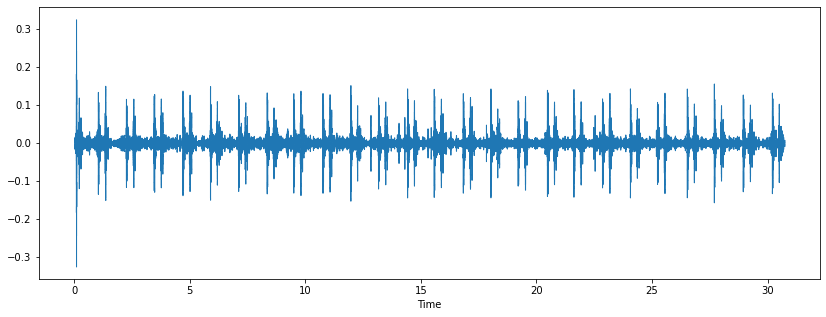

In [52]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

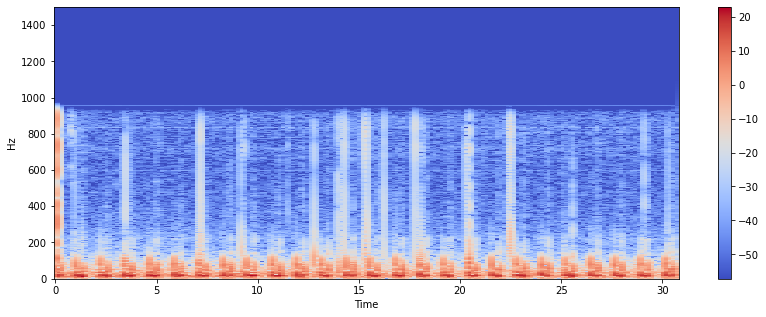

In [46]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
fig = plt.Figure()
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
fig.savefig(fig_path + '.png')